In [1]:
import pandas as pd
import scanpy as sc
import squidpy as sq
import cellcharter as cc
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('input_data/classified_csv_complete_binary_global.csv')

markers = ["PD1", "MHCII", "CD206", "CD45", "CD11C", "LY6G", "GRZB", "FOXP3", "CC3", 
           "CD8", "CD11B", "CD3", "LY6B2", "F480", "ASMA", "KI67", "PANCK"]

X = df[markers].values

obs = df[["sample_ID", "short_ID", "ObjectNumber", "class", "Tumor_ID", "Treatment", "slide", 
          "ROI_factor_per_tumor", "tum_factor_per_treatment"]].copy()

# Plug in Global coordinates for spatial information
spatial = df[["global_location_X", "global_location_Y"]].values

adata = ad.AnnData(X=X, obs=obs)

adata.var = pd.DataFrame(index=markers)
adata.var["marker"] = markers

adata.obsm["spatial"] = spatial

/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
print (adata)

AnnData object with n_obs × n_vars = 1695965 × 17
    obs: 'sample_ID', 'short_ID', 'ObjectNumber', 'class', 'Tumor_ID', 'Treatment', 'slide', 'ROI_factor_per_tumor', 'tum_factor_per_treatment'
    var: 'marker'
    obsm: 'spatial'


In [4]:
adata.write("anndata/classified_csv_complete_binary_global.h5ad")

In [12]:
#before analysis, make sure each sample will be scaled indepenendently.
adata = sc.read('anndata/classified_csv_complete_binary_global.h5ad')

for tumor in adata.obs['Tumor_ID'].cat.categories:
    adata.X[adata.obs['Tumor_ID'] == tumor, :] = sc.pp.scale(adata[adata.obs['Tumor_ID'] == tumor], copy=True).X

In [13]:
sq.gr.spatial_neighbors(adata)

/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: U

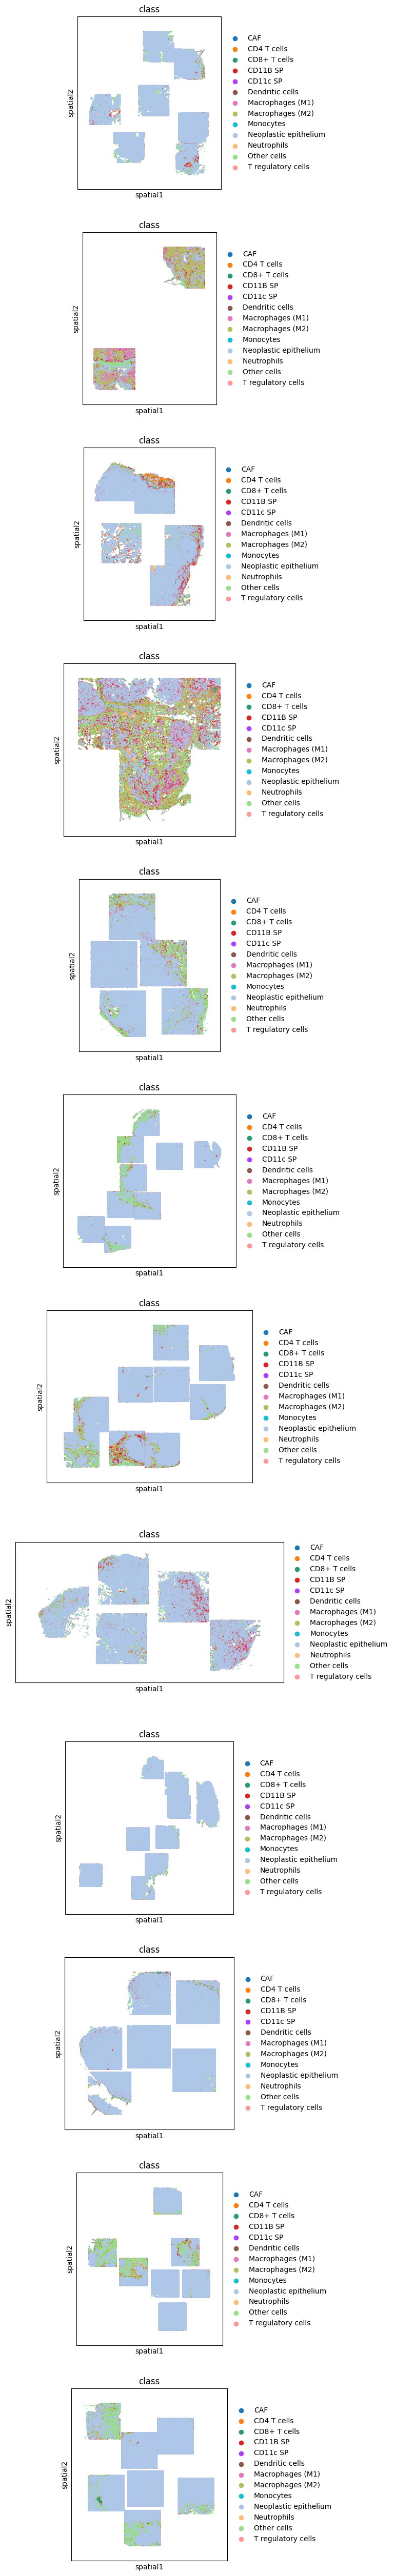

In [16]:
sq.pl.spatial_scatter(
    adata, 
    color='class', 
    shape=None,
    library_key='Tumor_ID', 
    ncols=1,
    size=0.5,
    connectivity_key='spatial_connectivities',
    edges_width= 0.2
    )

In [17]:
#for consistency, drop the long-distance connectivity 
cc.gr.remove_long_links(adata)

In [24]:
cc.gr.aggregate_neighbors(adata, n_layers=3)

100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.04s/it]


In [25]:
gmm = cc.tl.Cluster(n_clusters=5, random_state=12345)

In [26]:
gmm.fit(adata, use_rep='X_cellcharter')
adata.obs['spatial_cluster'] = gmm.predict(adata, use_rep='X_cellcharter')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 55: 100%|████████████████████████| 1/1 [00:02<00:00,  0.38it/s, nll=-106.]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|████████████████████| 1/1 [00:01<00:00,  0.74it/s]


/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: U

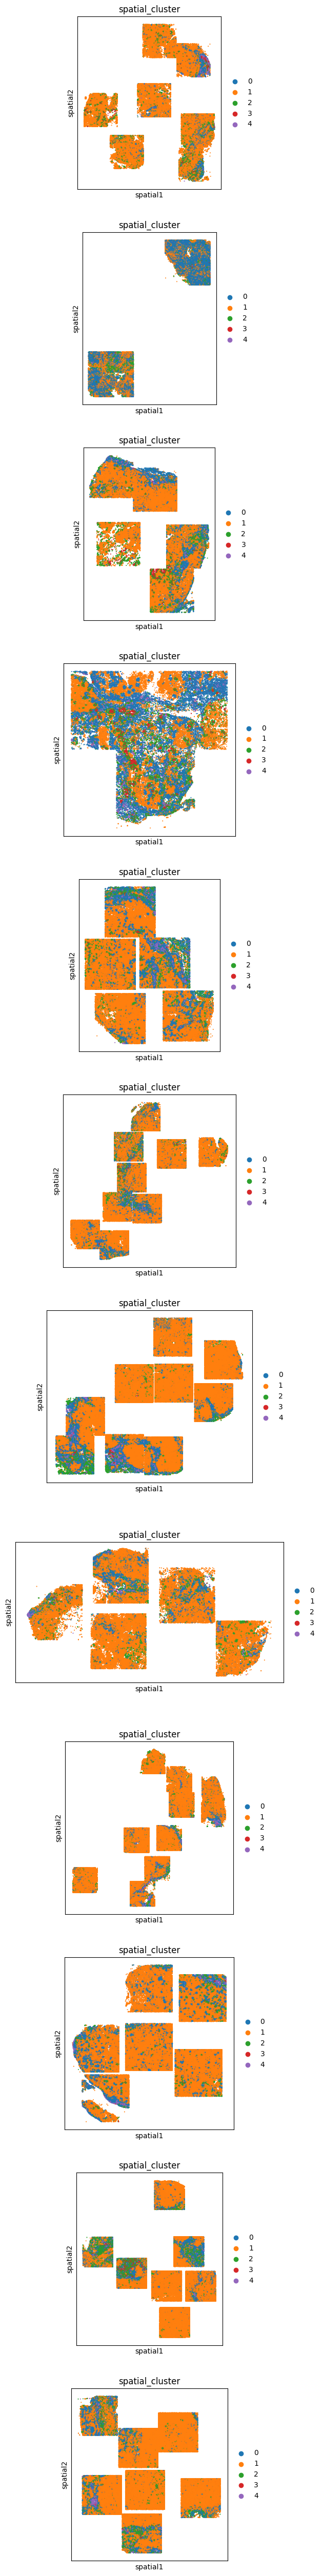

In [28]:
sq.pl.spatial_scatter(adata, 
                      shape=None, 
                      size=0.4, 
                      color="spatial_cluster", 
                      library_key='Tumor_ID',
                      ncols=1)

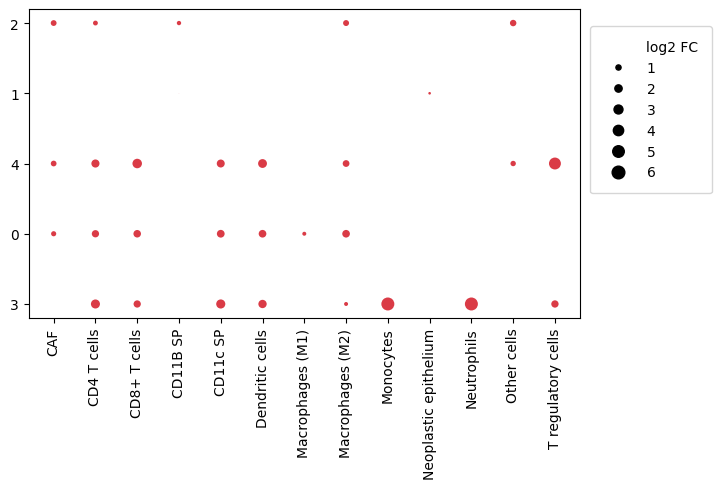

In [29]:
cc.gr.enrichment(adata, group_key='spatial_cluster', label_key='class')
cc.pl.enrichment(adata, group_key='spatial_cluster', label_key='class', figsize=(6,5), fontsize=10, dot_scale=2)

/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/cellcharter/gr/_nhood.py:236: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{cluster_key}_nhood_enrichment"] = result
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


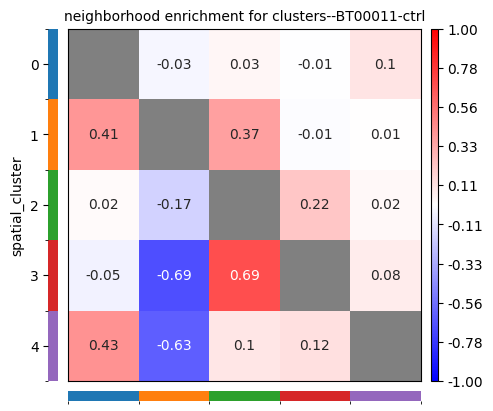

In [34]:
#neighborhood must be performed separately, to a subset. 
adata_BT00011 = adata[adata.obs['Tumor_ID'] == 'BT00011']
cc.gr.nhood_enrichment(adata_BT00011, cluster_key='spatial_cluster')
cc.pl.nhood_enrichment(
    adata_BT00011,
    cluster_key='spatial_cluster',
    annotate=True,
    vmin=-1,
    vmax=1,
    figsize=(4,4),
    fontsize=10,
    title = "neighborhood enrichment for clusters--BT00011-ctrl"
)

/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/cellcharter/gr/_nhood.py:236: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{cluster_key}_nhood_enrichment"] = result
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


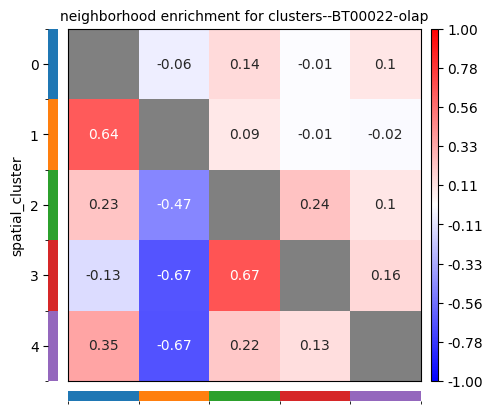

In [36]:
#neighborhood must be performed separately, to a subset. 
adata_BT00022 = adata[adata.obs['Tumor_ID'] == 'BT00022']
cc.gr.nhood_enrichment(adata_BT00022, cluster_key='spatial_cluster')
cc.pl.nhood_enrichment(
    adata_BT00022,
    cluster_key='spatial_cluster',
    annotate=True,
    vmin=-1,
    vmax=1,
    figsize=(4,4),
    fontsize=10,
    title = "neighborhood enrichment for clusters--BT00022-olap"
)

In [39]:
#differential neighborhood enrichment
cc.gr.diff_nhood_enrichment(
    adata,
    cluster_key='spatial_cluster',
    condition_key='Treatment',
    library_key='Tumor_ID',
    pvalues=True,
    n_jobs=15,
    n_perms=100
)

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame impleme

/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


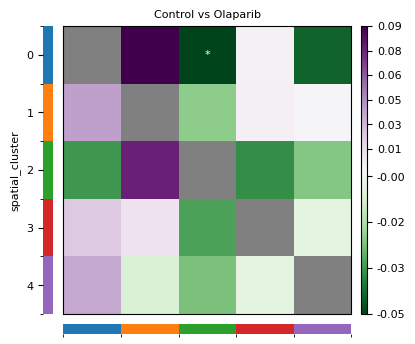

In [41]:
cc.pl.diff_nhood_enrichment(
    adata,
    cluster_key='spatial_cluster',
    condition_key='Treatment',
    condition_groups=['Control', 'Olaparib'],
    annotate=True,
    figsize=(4,4),
    significance=0.05,
    fontsize=8
)

In [42]:
print (adata)

AnnData object with n_obs × n_vars = 1695965 × 17
    obs: 'sample_ID', 'short_ID', 'ObjectNumber', 'class', 'Tumor_ID', 'Treatment', 'slide', 'ROI_factor_per_tumor', 'tum_factor_per_treatment', 'spatial_cluster'
    var: 'marker'
    uns: 'spatial_neighbors', 'class_colors', 'class_nhood_enrichment', '_cellcharter', 'spatial_cluster_colors', 'spatial_cluster_class_enrichment', 'spatial_cluster_Treatment_diff_nhood_enrichment'
    obsm: 'spatial', 'X_cellcharter'
    obsp: 'spatial_connectivities', 'spatial_distances'


In [45]:
adata.uns.pop('spatial_cluster_class_enrichment', None)
adata.uns.pop('spatial_cluster_Treatment_diff_nhood_enrichment', None)
adata.uns.pop('class_nhood_enrichment', None)

In [46]:
adata.write("anndata/classified_csv_complete_binary_global_annotated.h5ad")

In [47]:
print(adata)

AnnData object with n_obs × n_vars = 1695965 × 17
    obs: 'sample_ID', 'short_ID', 'ObjectNumber', 'class', 'Tumor_ID', 'Treatment', 'slide', 'ROI_factor_per_tumor', 'tum_factor_per_treatment', 'spatial_cluster'
    var: 'marker'
    uns: 'spatial_neighbors', 'class_colors', '_cellcharter', 'spatial_cluster_colors'
    obsm: 'spatial', 'X_cellcharter'
    obsp: 'spatial_connectivities', 'spatial_distances'


In [48]:
# Extract specific columns from obs
extracted_data = adata.obs[['class', 'short_ID', 'Tumor_ID', 'spatial_cluster']]

# Display the extracted data
print(extracted_data)


                         class                short_ID Tumor_ID  \
0                          CAF   Control_BT00011_ROI_1  BT00011   
1                          CAF   Control_BT00011_ROI_1  BT00011   
2                          CAF   Control_BT00011_ROI_1  BT00011   
3                          CAF   Control_BT00011_ROI_1  BT00011   
4                          CAF   Control_BT00011_ROI_1  BT00011   
...                        ...                     ...      ...   
1695960  Neoplastic epithelium  Olaparib_BT00023_ROI_7  BT00023   
1695961  Neoplastic epithelium  Olaparib_BT00023_ROI_7  BT00023   
1695962  Neoplastic epithelium  Olaparib_BT00023_ROI_7  BT00023   
1695963  Neoplastic epithelium  Olaparib_BT00023_ROI_7  BT00023   
1695964  Neoplastic epithelium  Olaparib_BT00023_ROI_7  BT00023   

        spatial_cluster  
0                     0  
1                     1  
2                     1  
3                     2  
4                     0  
...                 ...  
1695960      

In [50]:
extracted_data.to_csv("complete_spatial_cluster_extract.csv", index=False)  # Save as CSV